In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from sklearn import mixture

from pycaret.datasets import get_data
from pycaret.anomaly import *
from sklearn.ensemble import IsolationForest

from numpy.random import seed
import tensorflow as tf

import joblib
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

Using TensorFlow backend.


Enter the machine between 0 and 19: 0


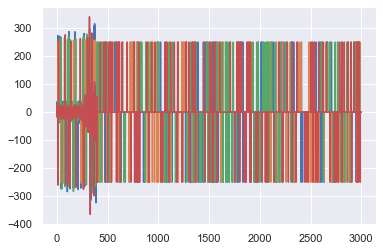

In [2]:
dataset_no=range(1,19)
dataset_no=str(input("Enter the machine between 0 and 19: "))
data = pd.read_csv('/exampleco_data/machine_'+dataset_no+'.csv',index_col=0)

plt.plot(range(len(data)), data)
plt.show()

Considering columns 0,1,2,3 to be Sensor 0, Sensor 1, Sensor 2, Sensor 3 respectively, we proceed further.

# Anomaly

In statistics, an anomaly is an observation or event that deviates so much from other events to arouse suspicion it was generated by a different mean. These need to be removed in order for the machine to not fail under a circumstance. If detected before, it can be fixed and got back to its normal state.

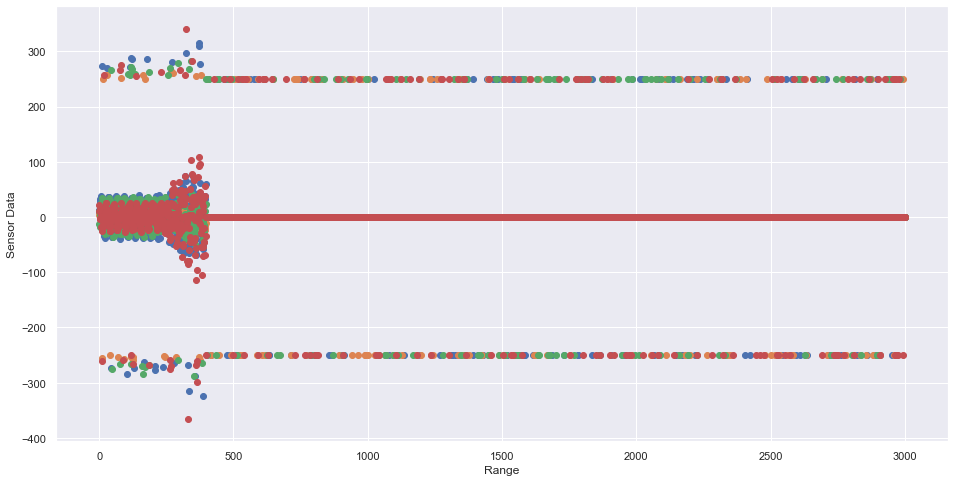

In [3]:
# choosing a scatter plot gives us a better understanding on where the outliers are with respect to the graph
range_data=range(len(data))
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(range_data, data['0'])
ax.scatter(range_data, data['1'])
ax.scatter(range_data, data['2'])
ax.scatter(range_data, data['3'])
ax.set_xlabel('Range')
ax.set_ylabel('Sensor Data')
plt.show()

# Z- score for outlier removal

We use the Z score to remove the outliers. The intuition behind Z-score is to describe any data point by finding their relationship with the Standard Deviation and Mean of the group of data points. Z-score is finding the distribution of data where mean is 0 and standard deviation is 1 i.e. normal distribution.

In [4]:
z = np.abs(stats.zscore(data))
print(z)

[[0.23148661 0.17682408 0.23133403 0.17430427]
 [0.20059037 0.06983364 0.18197354 0.38183763]
 [0.37713172 0.00748196 0.33800403 0.02662278]
 ...
 [0.01418524 0.01924    0.02263725 0.00289116]
 [0.01391227 0.01950475 0.02274678 0.00272834]
 [0.01411227 0.01992193 0.02220942 0.00266861]]


In [5]:
threshold = 3
print(np.where(z > 3))

(array([  10,   10,   11,   13,   17,   30,   31,   40,   43,   44,   49,
         70,   77,   79,   80,   83,   88,   94,  104,  106,  113,  116,
        118,  118,  119,  120,  120,  121,  122,  126,  127,  127,  131,
        133,  138,  161,  164,  165,  167,  170,  171,  177,  186,  187,
        187,  207,  209,  232,  237,  240,  245,  255,  262,  262,  265,
        266,  266,  270,  275,  278,  286,  292,  295,  302,  321,  322,
        323,  330,  331,  335,  335,  341,  346,  352,  356,  361,  361,
        364,  366,  370,  373,  373,  375,  375,  380,  382,  385,  398,
        399,  403,  405,  406,  408,  416,  417,  428,  435,  439,  445,
        447,  463,  466,  475,  477,  478,  482,  487,  487,  492,  496,
        500,  507,  508,  514,  516,  522,  523,  526,  526,  529,  532,
        532,  533,  539,  544,  545,  555,  563,  577,  586,  587,  589,
        590,  591,  595,  607,  611,  612,  612,  617,  617,  626,  627,
        632,  633,  643,  646,  647,  661,  675,  

The first array contains the list of row numbers and second array respective column numbers, which means z[10][0] have a Z-score higher than 3.

In [6]:
print(z[10][0])

4.732787675295513


While calculating the Z-score we re-scale and center the data and look for data points which are too far from zero. These data points which are way too far from zero will be treated as the outliers. In most of the cases a threshold of 3 or -3 is used i.e if the Z-score value is greater than or less than 3 or -3 respectively, that data point will be identified as outliers.

In [7]:
data_outliers = data[(z < 3).all(axis=1)]
data_outliers_copy=data_outliers.copy(deep=True)

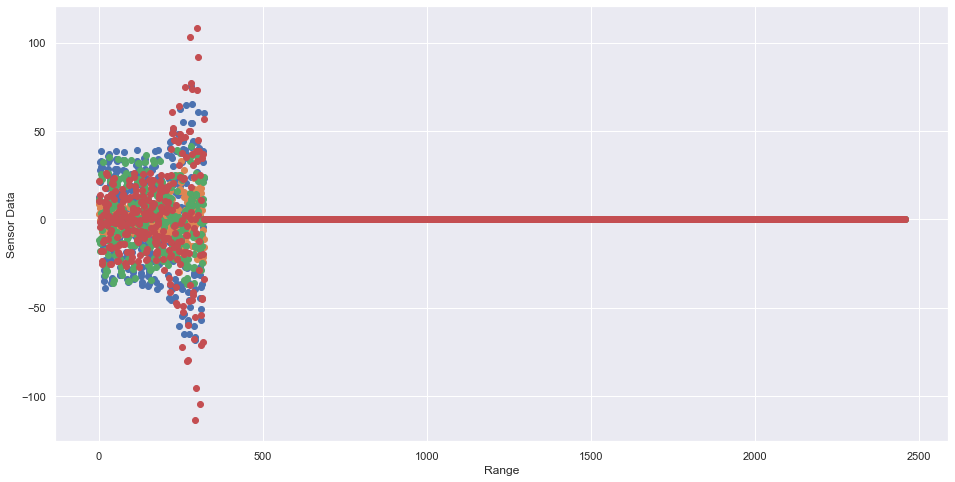

In [8]:
#Visualising the outlier eliminated data
range_data_o=range(len(data_outliers_copy))
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(range_data_o, data_outliers_copy['0'])
ax.scatter(range_data_o, data_outliers_copy['1'])
ax.scatter(range_data_o, data_outliers_copy['2'])
ax.scatter(range_data_o, data_outliers_copy['3'])
ax.set_xlabel('Range')
ax.set_ylabel('Sensor Data')
plt.show()

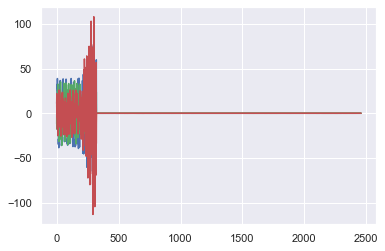

In [9]:
plt.plot(range(len(data_outliers_copy)), data_outliers_copy)
plt.show()

# Gaussian Mixture Model for Clustering

Clustering refers to grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters)

Gaussian Mixture Models (GMMs) assume that there are a certain number of Gaussian distributions, and each of these distributions represent a cluster. Hence, a Gaussian Mixture Model tends to group the data points belonging to a single distribution together.

Advantage over other algotithms used for clustering :
1. Other algorithms does not account for variance. By variance, we are referring to the width of the bell shape curve. One way to think about the model is that it places a circle at the center of each cluster, with a radius defined by the most distant point in the cluster.

2. Other algorithms tells us what data point belong to which cluster but won’t provide us with the probabilities that a given data point belongs to each of the possible clusters.

Disadvantage :
1. The model assumes that each pixel is independent of its neighbors. It is well known that pixels in an image are similar in some sense and cannot be classified consistently based on feature attributes alone. Thus, the segmentation result of GMM is extremely sensitive to noise.

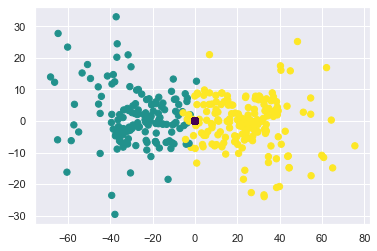

In [10]:
#splitting them into 3 clusters :
X=data_outliers_copy.to_numpy()
model = mixture.GaussianMixture(n_components=3, covariance_type='full',random_state=3458).fit(X)
labels = model.predict(X)
#below image plots only two column values for covenience.
plt.scatter(X[:, 0], X[:, 1],c=labels, s=40 ,cmap='viridis')

In [11]:
#getting the labelled clustered data into the dataset
Clusters=pd.DataFrame(labels)
Clusters.reset_index(drop=True, inplace=True)
data_outliers_copy.reset_index(drop=True, inplace=True)
Clustered_data = pd.concat([Clusters, data_outliers_copy], axis=1)
Clustered_data.columns.values[0] = "Clusters"
Clustered_data.index=data_outliers.index

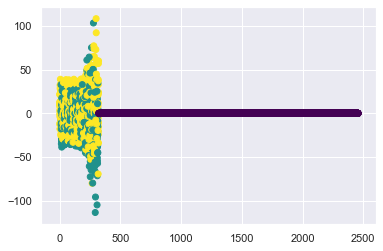

In [12]:
#visualising the clusters for the whole dataset
range_data_c=range(len(Clustered_data))
colors=Clustered_data["Clusters"]
plt.scatter(range_data_c, Clustered_data["0"],c=colors,cmap='viridis')
plt.scatter(range_data_c, Clustered_data["1"],c=colors,cmap='viridis')
plt.scatter(range_data_c, Clustered_data["2"],c=colors,cmap='viridis')
plt.scatter(range_data_c, Clustered_data["3"],c=colors,cmap='viridis')
plt.show()

As we can see from above, the Gaussian mixture model has split the data into 3 components - one is failed which is clustered almost perfectly and the rest is unclear since they appear very close which is unlikely for faulty and normal data to be that way.
Therefore, we try the next algorithm to seperate the normal from the faulty.

# Isolation Forest Implementation
Isolation forest is an unsupervised learning algorithm for anomaly detection that works on the principle of isolating anomalies,instead of the most common techniques of profiling normal points. 

The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature which is exactly what we need here

In [13]:
setup_anomaly_data = setup(Clustered_data)
iforest = create_model("iforest")

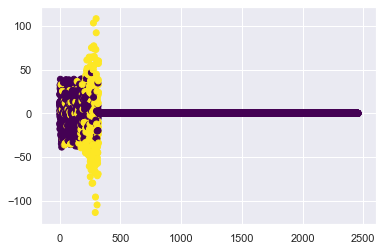

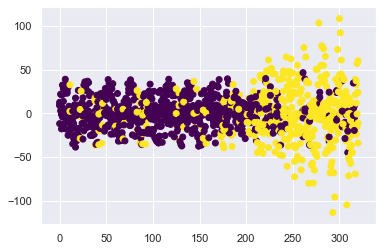

In [14]:
#predicting and visualising our model
iforest_predictions = predict_model(iforest, data = Clustered_data)
iforest_anomaly_rows = iforest_predictions[iforest_predictions["Label"] == 1]
range_data_f=range(len(iforest_predictions))
colors1=iforest_predictions["Label"]
plt.scatter(range_data_f, iforest_predictions["0"],c=colors1,cmap='viridis')
plt.scatter(range_data_f, iforest_predictions["1"],c=colors1,cmap='viridis')
plt.scatter(range_data_f, iforest_predictions["2"],c=colors1,cmap='viridis')
plt.scatter(range_data_f, iforest_predictions["3"],c=colors1,cmap='viridis')
plt.show()
Eliminate=iforest_predictions[iforest_predictions["Clusters"]!=0]
range_data_e=range(len(Eliminate))
colors2=Eliminate["Label"]
plt.scatter(range_data_e, Eliminate["0"],c=colors2,cmap='viridis')
plt.scatter(range_data_e, Eliminate["1"],c=colors2,cmap='viridis')
plt.scatter(range_data_e, Eliminate["2"],c=colors2,cmap='viridis')
plt.scatter(range_data_e, Eliminate["3"],c=colors2,cmap='viridis')
plt.show()

Label = 0 means normal data or inlier.
Label = 1 means an anomaly or outlier

From the above, we can see that the normal and faulty data have been split to an extent by the algorithm. The normal data being purple and the faulty data being yellow.

Splitting the train and test data such that we train on normal data and test on faulty/failed data.

Some machines had faulty data starting from the start with zero normal data. Hence our train dataset was empty and therefore those cases should be corrected at the start itself.

In [15]:
#combining 0 from Gaussian clustering(failure data) and 1 from Isolation Forest (faulty data)
train=Eliminate[Eliminate["Label"]==0]
temp=Eliminate[Eliminate["Label"]==1]
temp1=iforest_predictions[iforest_predictions["Clusters"]==0]
test=pd.concat([temp, temp1], axis=0)
train.drop(['Score','Clusters','Label'],axis=1,inplace=True)
test.drop(['Score','Clusters','Label'],axis=1,inplace=True)
if train.empty:
    print("The system is faulty/not normal and anomalous from the start, please check the machine. Do not proceed further.")
else:
    print("Proceed further to train and test and mark the faulty threshold")

Proceed further to train and test and mark the faulty threshold


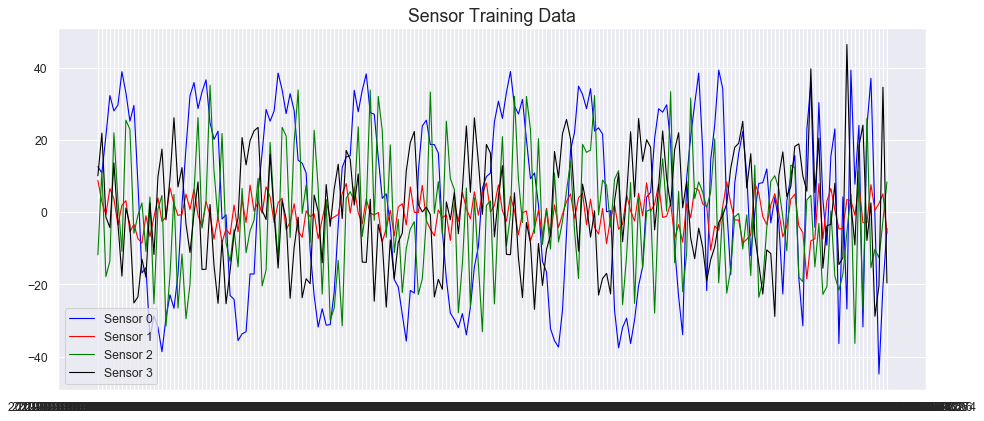

In [16]:
#visualising the training data for the sensors
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['0'], label='Sensor 0', color='blue', animated = True, linewidth=1)
ax.plot(train['1'], label='Sensor 1', color='red', animated = True, linewidth=1)
ax.plot(train['2'], label='Sensor 2', color='green', animated = True, linewidth=1)
ax.plot(train['3'], label='Sensor 3', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sensor Training Data', fontsize=16)
plt.show()


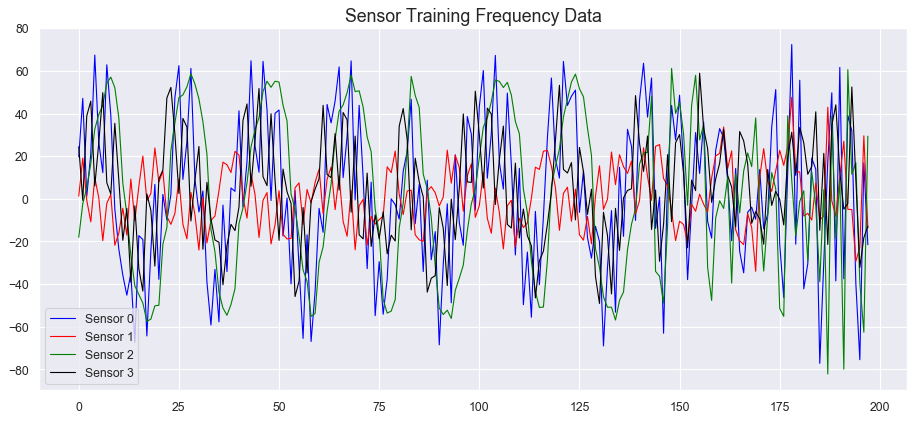

In [17]:
#getting a different perspective of the data by transforming the signal from the time domain to the frequency domain using a discrete Fourier transform.
#The Fourier transform is a mathematical function that can be used to find the base frequencies that make up a signal or wave
#Fourier Transform is a mathematical operation that changes the domain(x-axis, in this case) of a signal from time to frequency.
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Sensor 0', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Sensor 1', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Sensor 2', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Sensor 3', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sensor Training Frequency Data', fontsize=16)
plt.show()

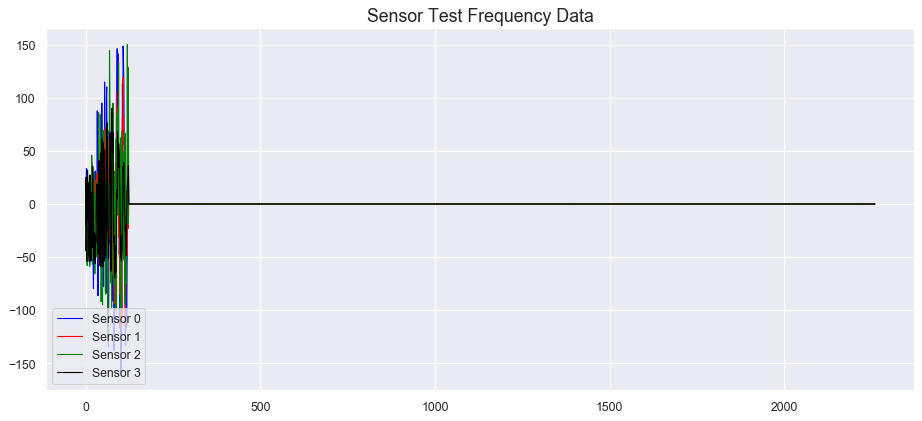

In [18]:
#frequencies of the degrading sensor signal or the test signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Sensor 0', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Sensor 1', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Sensor 2', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Sensor 3', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sensor Test Frequency Data', fontsize=16)
plt.show()

From the above, We can clearly see an increase in the frequency amplitude and energy in the system and leads up to a constant line which is failure.

To complete the pre-processing of our data, we will first normalize it to a range between 0 and 1. Then we reshape our data into a format suitable for input into an LSTM network. LSTM cells expect a 3 dimensional tensor of the form - data, time, features. Here, each sample input into the LSTM network represents one step in time and contains 4 features — the sensor readings for the four bearings at that time step.

# LSTM Autoencoder 

An autoencoder is a neural network model that seeks to learn a compressed representation of an input.

The autoencoder network is trained on data representing the “normal” operating state, with the goal of first compressing and then reconstructing the input variables. During the dimensionality reduction, the network learns the interactions between the various variables and should be able to re-construct them back to the original variables at the output. The main idea is that as the monitored equipment degrades, this should affect the interaction between the variables.

An LSTM(Long Short Term Memory) Autoencoder is an implementation of an autoencoder for sequence data using an Encoder-Decoder LSTM architecture. Once fit, the encoder part of the model can be used to encode or compress sequence data.

In simpler words, For a given dataset of sequences, an encoder-decoder LSTM is configured to read the input sequence, encode it, decode it, and recreate it. The performance of the model is evaluated based on the model’s ability to recreate the input sequence.

We use the autoencoder neural network architecture for our anomaly detection model. The autoencoder architecture essentially learns an “identity” function. It will take the input data, create a compressed representation of the core / primary driving features of that data and then learn to reconstruct it again.

In [19]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [20]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (198, 1, 4)
Test data shape: (2260, 1, 4)


In [21]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In the LSTM autoencoder network architecture, the first couple of neural network layers create the compressed representation of the input data, the encoder. We then use a repeat vector layer to distribute the compressed representational vector across the time steps of the decoder. The final output layer of the decoder provides us the reconstructed input data.

In [22]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 4)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 4)              68  

In [23]:
#Finally, we fit the model to our training data and train it for 100 epochs. We then plot the training losses to evaluate our model’s performance.
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Train on 188 samples, validate on 10 samples
Epoch 1/100
188/188 [==============================] - 2s 12ms/step - loss: 0.5218 - val_loss: 0.5094
Epoch 2/100
188/188 [==============================] - 0s 726us/step - loss: 0.5000 - val_loss: 0.4895
Epoch 3/100
188/188 [==============================] - 0s 754us/step - loss: 0.4764 - val_loss: 0.4678
Epoch 4/100
188/188 [==============================] - 0s 653us/step - loss: 0.4508 - val_loss: 0.4437
Epoch 5/100
188/188 [==============================] - 0s 640us/step - loss: 0.4228 - val_loss: 0.4165
Epoch 6/100
188/188 [==============================] - 0s 1ms/step - loss: 0.3905 - val_loss: 0.3855
Epoch 7/100
188/188 [==============================] - 0s 823us/step - loss: 0.3504 - val_loss: 0.3425
Epoch 8/100
188/188 [==============================] - 0s 892us/step - loss: 0.2897 - val_loss: 0.2621
Epoch 9/100
188/188 [==============================] - 0s 1ms/step - loss: 0.2104 - val_loss: 0.2235
Epoch 10/100
188/188 [===========

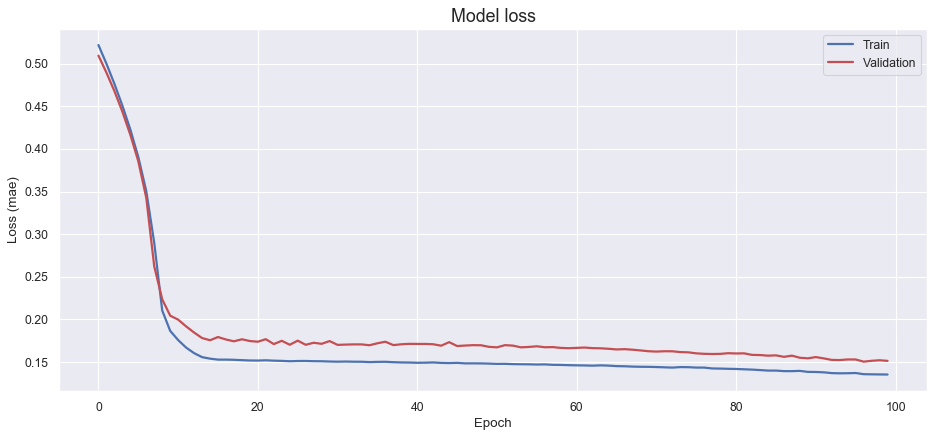

In [24]:
#visualisation of model loss - training and validation loss in mean absolute error
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.5)

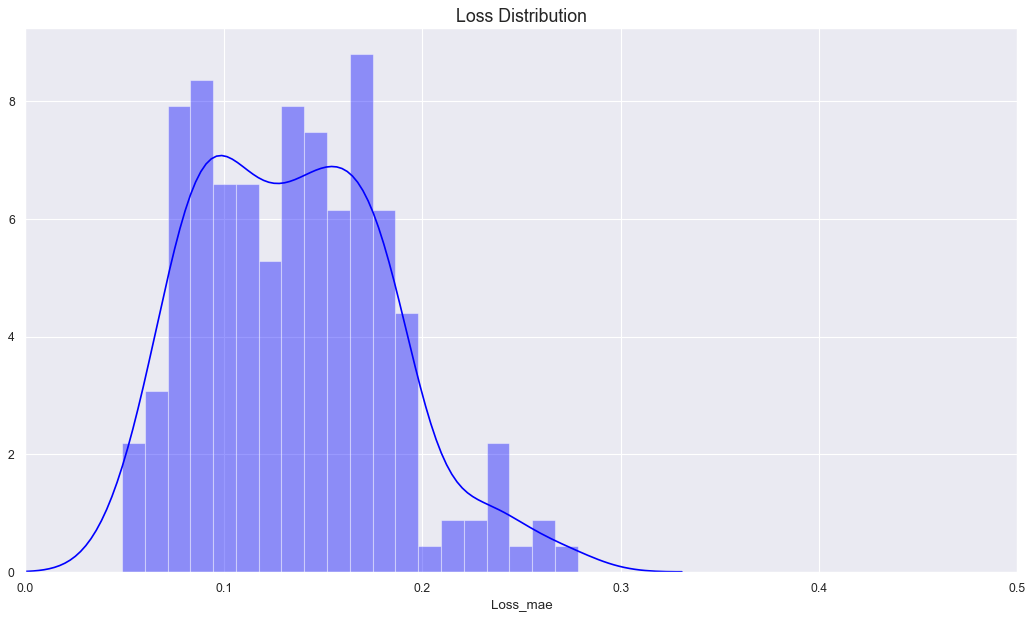

In [25]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

By plotting the distribution of the calculated loss in the training set, we can determine a suitable threshold value for identifying an anomaly. 
We set the threshold by using the function μ+3σ which basically means we take 99.7% of the normal data.
The lower threshold is set to a 0.035 value just above the failure mode mae.
In doing this, one can make sure that this threshold is set above the “noise level” so that false positives are not triggered.

In [32]:
#calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
score_mean=np.mean((scored['Loss_mae']))
score_std=np.std((scored['Loss_mae']))
scored['Upper_threshold'] = np.abs(score_mean+(3*score_std))
scored['Lower_threshold']=0.035
scored['Anomaly1'] = scored['Loss_mae'] > scored['Upper_threshold']
scored['Anomaly2'] = scored['Loss_mae']< scored['Lower_threshold']
scored.head()

,Loss_mae,Upper_threshold,Lower_threshold,Anomaly1,Anomaly2
2019-01-05 16:02:14.444814938,0.192575,0.251798,0.035,False,False
2019-01-09 16:04:09.683227742,0.186980,0.251798,0.035,False,False
2019-01-10 00:04:19.286428809,0.194030,0.251798,0.035,False,False
2019-01-16 16:07:31.350450150,0.219464,0.251798,0.035,False,False
2019-01-18 08:08:19.366455485,0.144785,0.251798,0.035,False,False


(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 <a list of 8 Text xticklabel objects>)

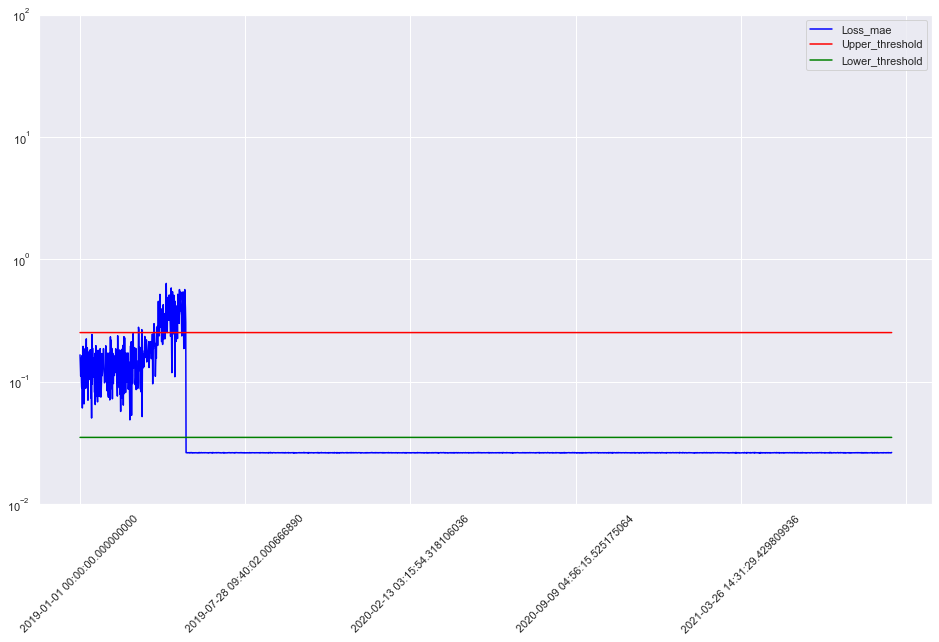

In [33]:
#visualizing the time plot along with its threshold
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Upper_threshold'] = np.abs(score_mean+(3*score_std))
scored_train['Lower_threshold']= 0.035
scored_train['Anomaly1'] = scored_train['Loss_mae'] > scored_train['Upper_threshold']
scored_train['Anomaly2'] = scored_train['Loss_mae']< scored_train['Lower_threshold']
scored = pd.concat([scored_train, scored])

scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red','green'])
plt.xticks(rotation=45) 

The area above upper threshold(red line) is the faulty mode and the area below the lower threshold(green line) is the failed mode following the faulty mode. If the normal mode is touching the lower boundary, it will not make a difference because a machine goes from normal to *faulty* to failed to be affected by the lower boundary and not directly from normal to failed.

In [28]:
#We create an ID to keep track of the rows which will be used later on.
scored['New_ID'] = range(0, 0+len(scored))
Anomaly_filtered = scored[scored['Anomaly1'] == True] 
Anomaly_filtered.head()

,Loss_mae,Upper_threshold,Lower_threshold,Anomaly1,Anomaly2,New_ID
2019-03-29 00:41:46.435478493,0.278328,0.251798,0.035,True,False,177
2019-04-01 16:43:32.070690230,0.265569,0.251798,0.035,True,False,178
2019-04-17 00:50:53.817939314,0.266221,0.251798,0.035,True,False,187
2019-03-17 16:36:19.926642214,0.297953,0.251798,0.035,True,False,224
2019-03-18 00:36:29.529843281,0.274690,0.251798,0.035,True,False,225


# Setting threshold for Fault 

We filter out the data which is above the upper threshold.(red line) We find out the count of faulty data for the three days from all the filtered out dates.

We find the maximum count number and subract 2 from that, so that the faulty data can be identified 2 counts before it shuts down and repaired to go back to its normal state, which is represented as n. The model identifies the threshold for fault only if the machines have been persistantly faulting for the past 3 days and 2 *fault occurances* before it enters into the failed mode. 

In [29]:
Anomaly_filtered['Date'] = Anomaly_filtered.index
Anomaly_filtered.Date = pd.to_datetime(Anomaly_filtered.Date)
Anomaly_filtered = Anomaly_filtered.sort_index()
delta = 3
Anomaly_filtered['count_in_last_%s_days' %(delta)] = Anomaly_filtered.assign(count=1).groupby(
    ['Anomaly1']).apply(lambda x: x.rolling('%sD' %delta, on='Date').sum())['count'].astype(int)
n=len(set(Anomaly_filtered['count_in_last_3_days']))-2
n

7

Visualising the points which are greater than n. The vertical line indicates the faulty state during which the machine should be checked and repaired to not enter into the failed mode 

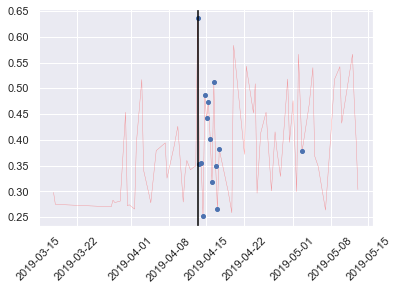

In [30]:
col1=Anomaly_filtered['Date']
col2=Anomaly_filtered['Loss_mae']
index=Anomaly_filtered['count_in_last_3_days']>=n
c=col1[index][0]
plt.plot(col1,col2, lw=0.4, alpha=0.4,color="red" )
plt.plot(col1[index],col2[index], marker="o", ls="", ms=4 )
plt.xticks(rotation=45) 
plt.plot()
plt.axvline(x=c,color="black")

Visualising the threshold for fault in the main graph

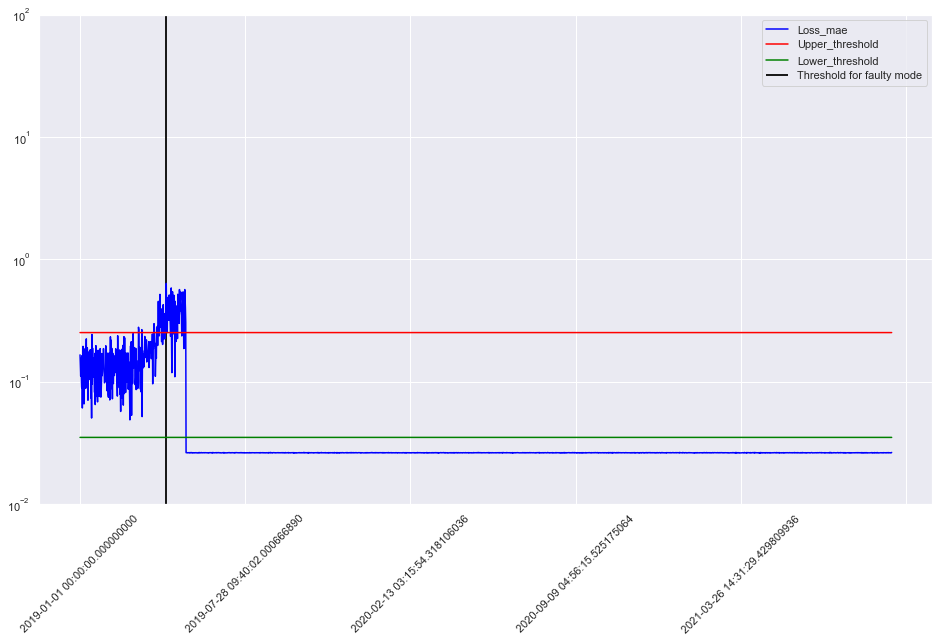

In [34]:
Anomaly_filtered1=Anomaly_filtered[Anomaly_filtered['count_in_last_3_days']>=n]
c=Anomaly_filtered1["New_ID"][0]
y_min=scored.Loss_mae.min()-20
y_max=scored.Loss_mae.max()+10000
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red','green','white','black'])
plt.xticks(rotation=45) 
plt.vlines(x=c, ymin=y_min, ymax=y_max, lw=2, label='Threshold for faulty mode')
plt.legend()
plt.show()

# Strengths :

1. As we know human beings don’t start their thinking from scratch at every second, i.e. we understand every word based on our previous word's understanding. Also, we don’t throw everything away and start thinking from scratch again. Our thoughts have persistence. Traditional neural networks can’t do like this and it seems shortcoming but LSTM addresses this issue. They are networks with loops in them, allowing information to persist. 

2. The model is flexible to apply across different scales.

3. The experimental results show that the AE-LSTM method had higher prediction accuracy. Specifically, the MAE of the AE-LSTM was reduced by 0.01 compared with the previous prediction methods. In addition, AE-LSTM method also had good stability. For different stations and different dates, the prediction error and fluctuation of the AE-LSTM method was small.

# Limitations :

1. The autoencoder might be more sensitive to input errors different from those in the training set, or to changes in underlying relationships that a human would notice.

2. Training an AE-LSTM is a lot of data, processing time, hyperparameter tuning, and model validation before we even start building the real model.

3. The problem with LSTM is that we are not too sure about Feature importance.

# Alternate Aproaches :

I would be tried the traditional ARIMA approach to time series anomaly detection using Convolutional Neural Networks to detect patterns and find the point of failure and fatigue in the graph because unlike RNN's, with ARIMA we are able to assign feature importance manually giving us a complete understanding of the results.

Using the same parameter based semi supervised model to cater to all machines was also a disadvantage here.